# Phonopy in pyiron

We will use the quasi-harmonic approximation (via PyIron's implementation of the popular phonopy package) to evaluate look at thermal expansion and self-diffusion in Aluminium

In [1]:
# Generic imports
from pyiron_atomistics import Project
import numpy as np
%matplotlib  inline
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
pr = Project("PhonopyExample")
pot = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'

## Helper functions

Because repeating code is evil.

In [3]:
def make_phonopy_job(template_job, name):
    """
    Create a phonopy job from a reference job.
    
    Args:
        template_job (pyiron job): The job to copy.
        name (str): What to call this new job.
        
    Returns:
        A new phonopy job.
    """
    project = template_job.project
    
    # What I want:
    # job_type =  template_job.job_type
    # What I have to do instead:
    job_type = pr.job_type.Lammps
    
    ref = project.create_job(job_type, name + "_ref")
    ref.structure = template_job.get_structure().copy()
    ref.potential = template_job.potential
    
    phono = project.create_job(pr.job_type.PhonopyJob, name)
    phono.ref_job = ref
    return phono

In [4]:
def scale_array(arr, scaler=None, new_range=1.):
    """
    Linearly transforms an array so that values equal to the minimum and maximum of the 
    `scaler` array are mapped to the range (0, `new_range`). Note that rescaled values can 
    still lie outside this range if the orignal values of `arr` are outside the bounds of 
    `scaler`.
    
    Args:
        arr (np.array): Array to rescale.
        scaler (np.array): Array by which to rescale. Default is `arr`.
        new_range (float): New value for data which was the size `np.amax(scaler)`. 
          Default is 1.
    """
    if scaler is None:
        scaler = arr
    return new_range * (arr - np.amin(scaler)) / np.ptp(scaler)

## Thermal Expansion

What does the QHA say the lattice constant is as a function of temperature?

In [5]:
pr_te = pr.create_group("ThermalExpansion")

### Relax the unit cell

If we were doing VASP instead it would be important to do the least computation as possible, so here we'll start by relaxing a simple unit cell to turn into a supercell later.

In [6]:
job_unit = pr_te.create_job(pr.job_type.Lammps, "UnitCell")

In [7]:
basis = pr_te.create_structure("Al", "fcc", 4.04)

In [8]:
job_unit.structure = basis
job_unit.potential = pot

In [9]:
job_unit.calc_minimize(pressure=0.0)
job_unit.run()

2021-01-25 01:54:40,391 - pyiron_log - WARNING - The job UnitCell is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [10]:
basis_rel = job_unit.get_structure()

### Relax the bulk supercell

A relaxation which should take zero steps given our starting position!

In [11]:
job_bulk_1 = pr_te.create_job(pr.job_type.Lammps, "Bulk_1")
# The _1 here refers to the fact that the volume has been rescaled by a factor of "1.0"
# (i.e. it hasn't been rescaled)

In [12]:
n_reps = 3
job_bulk_1.structure = basis_rel.repeat(rep=n_reps)
job_bulk_1.potential = pot

In [13]:
job_bulk_1.structure.plot3d();

In [14]:
job_bulk_1.calc_minimize(pressure=0.0)
job_bulk_1.run()

2021-01-25 01:54:41,327 - pyiron_log - WARNING - The job Bulk_1 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


### Calculate phonons

Run phonopy on the bulk supercell

In [15]:
phono_bulk_1 = make_phonopy_job(job_bulk_1, "PhonoBulk_1")

In [16]:
phono_bulk_1.run()
# Run performs a whole bunch of child calculations
# Each one has the positions slightly deformed in the symmetry-appropriate ways needed
# to get the phonon properties

2021-01-25 01:54:42,849 - pyiron_log - WARNING - The job PhonoBulk_1 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [17]:
# Let's see what we got...
T_min = 0
T_max = 800 # a bit below melting
T_step = 25
temperatures = np.linspace(T_min, T_max, int((T_max - T_min) / T_step))
tp_bulk_1 = phono_bulk_1.get_thermal_properties(temperatures=temperatures) 
# `get_thermal_properties` uses the displacements and forces to generate phonon information

Text(0, 0.5, 'Free energy  ($U+F_{vib}$)  [eV]')

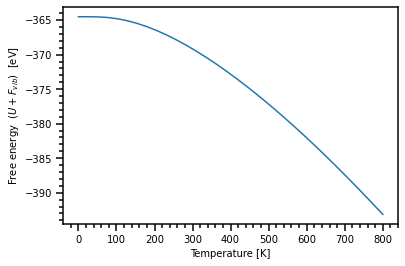

In [18]:
U_bulk_1 = job_bulk_1.output.energy_pot[-1]
Fvib_bulk_1 = tp_bulk_1.free_energies
plt.plot(temperatures, U_bulk_1 + Fvib_bulk_1)
plt.xlabel("Temperature [K]")
plt.ylabel("Free energy  ($U+F_{vib}$)  [eV]")

### Calculate thermal expansivity

Above we have the (QHA approximation to the) free energy as a function of temperature at a fixed volume. To evaluate the thermal expansivity, we need to create the entire F(V,T) surface. To get this, we just loop over jobs like the above, but scaled to have different lattice constants.

In [19]:
# According to Wikipedia, the thermal expansivity is about 0.0023% / Kelvin
# So at our maximum temperature, we expect around 1.8% expansion
scale_min = -0.005
scale_max = 0.02
scale_step = 0.002
scales = np.linspace(scale_min, scale_max, int((scale_max - scale_min) / scale_step))

In [20]:
# Let's keep things clean by making another sub-directory
pr_scales = pr_te.create_group("ScanScales")

In [21]:
# Loop the phonon calculation over all the volumes
sc_bulk_rel = job_bulk_1.get_structure()
bulk_free_energies = np.zeros((len(scales), len(temperatures)))

for i, scale in enumerate(scales):
    name_tail = "_{}".format(str(scale).replace(".", "c").replace('-', 'm'))
    
    # Make a bulk job with the rescaled structure 
    # (already relaxed, by symmetry won't change, calc static will be enough)
    job_bulk = pr_scales.create_job(pr.job_type.Lammps, "Bulk" + name_tail)
    job_bulk.potential = pot
    job_bulk.structure = sc_bulk_rel.apply_strain(epsilon=scale, return_box=True)
    job_bulk.calc_static()
    job_bulk.run()
    U = job_bulk.output.energy_tot[-1]
    
    # Use that job as a reference for a phonopy job
    phono_bulk = make_phonopy_job(job_bulk, "PhonoBulk" + name_tail)
    phono_bulk.run()
    tp_bulk = phono_bulk.get_thermal_properties(temperatures=temperatures) 
    Fvib = tp_bulk.free_energies
    
    # Fill in the row of free energies for this volume
    bulk_free_energies[i] = Fvib + U

2021-01-25 01:54:44,470 - pyiron_log - WARNING - The job Bulk_m0c005 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-01-25 01:54:46,041 - pyiron_log - WARNING - The job PhonoBulk_m0c005 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-01-25 01:54:46,901 - pyiron_log - WARNING - The job Bulk_m0c002727272727272727 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-01-25 01:54:48,440 - pyiron_log - WARNING - The job PhonoBulk_m0c002727272727272727 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-01-25 01:54:49,311 - pyiron_log - WARNING - The job Bulk_m0c000454545454545454 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-01-25 01:54:50,870 - pyiron_log - WARNING - The job PhonoBulk_m0c0004545454

In [22]:
# The lattice constant is probably a more informative value than the 0K-relative strain
latts = basis_rel.cell[0][0] * scales

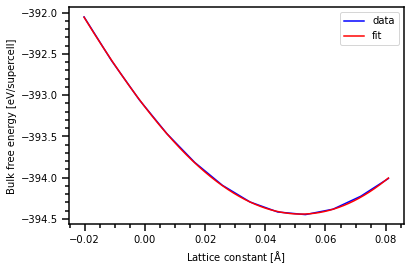

In [23]:
# At each temperature, find the optimal volume by a simple quadratic fit
# ...Wait, which order fit will be good enough? Let's just spot-check
free_en = bulk_free_energies[:, -1]
plt.plot(latts, free_en, color='b', label='data')

# We'll plot the fit on a much denser mesh
fit_deg = 4
p = np.polyfit(latts, free_en, deg=fit_deg)
dense_latts = np.linspace(np.amin(latts), np.amax(latts), 1000)
#dense_latts = np.linspace(0, 10, 1000)
plt.plot(dense_latts, np.polyval(p=p, x=dense_latts), color='r', label='fit')
plt.xlabel('Lattice constant [$\mathrm{\AA}$]')
plt.ylabel('Bulk free energy [eV/supercell]')
plt.legend()
# Ok, a fourth-order fit seems perfectly reasonable

In [24]:
# Now find optimal temperatures
best_latts = np.zeros(len(temperatures))
best_latt_guess = basis_rel.cell[0][0]
for i, T in enumerate(temperatures):
    free_en = bulk_free_energies[:, i]
    p = np.polyfit(latts, free_en, deg=fit_deg)
    extrema = np.roots(np.polyder(p, m=1)).real  # Find where first-derivative is zero
    best_latts[i] = extrema[np.argmin(np.abs(extrema - best_latt_guess))]

In [25]:
# Check that they're resonable
print(best_latt_guess, '\n', best_latts)

4.045270475668763 
 [0.11555208 0.11352381 0.10694858 0.10163591 0.09885117 1.43575215
 0.77014514 0.60322654 0.51918731 0.46683396 0.43047158 0.40346597
 0.3824714  0.3655972  0.35168586 0.33998505 0.32998258 0.32131652
 0.31372321 0.3070056  0.30101322 0.295629   0.29076035 0.28633304
 0.28228676 0.27857199 0.27514762 0.27197926 0.26903787 0.26629874
 0.26374073 0.26134559]


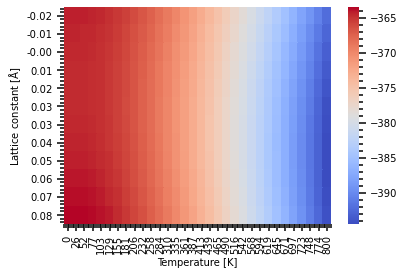

In [26]:
# Let's look at the landscape
fig, ax = plt.subplots()
sns.heatmap(bulk_free_energies, ax=ax, cmap="coolwarm",
            xticklabels=['{:,.0f}'.format(T) for T in temperatures],
            yticklabels=['{:,.2f}'.format(a) for a in latts])
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Lattice constant [$\mathrm{\AA}$]")

# Overlaying the optimal path takes a couple changes of variables
# since the heatmap is plotting integer cells


ax.plot(scale_array(temperatures, new_range=len(temperatures)), 
        scale_array(best_latts, scaler=latts, new_range=len(latts)), 
        color='k')


## Vacancies and diffusion

Another common use of QHA is to calculate the pre-factor for migration in a diffusion event.

In particular, the diffusion jump barrier looks like $\omega_0 = \nu_0^\star \exp(-H_\mathrm{m} / k_\mathrm{B} T)$, where $\nu_0^\star = \prod_{i=1}^{3N-3} \nu_i^\mathrm{IS} / \prod_{i=1}^{3N-4} \nu_i^\mathrm{TS}$, with IS and TS indicating the initial and transition states, respectively. Note that the transition state is missing a single frequency, which is from the instability of the transition state. It's either an imaginary mode, which I think means a negative frequency. Meanwhile, $H_\mathrm{m}$ is the enthalpic barrier (difference between the initial and transition states) and $k_\mathrm{B} T$ is the usual thermal energy term.

Typically, these sorts of investigations use the nudged elastic band (NEB) to find the 0K transition state. You can do that with our new flexible jobs, but we'll save that for later. For now we'll just "approximate" the transition state with a simple linear interpolation.

### Stable vacancy structures

Let's start by generating and relaxing the initial and final states

In [27]:
pr_vac = pr.create_group("Vacancies")

In [28]:
# Find two adjacent sites
print(job_bulk_1.structure.positions[0])
print(job_bulk_1.structure.positions[1])
# Yep, 1 and 2 will do

[0. 0. 0.]
[ 2.02263524e+00  2.02263524e+00 -7.63052415e-33]


In [29]:
job_vac_i = pr_vac.create_job(pr.job_type.Lammps, "VacancyInitial")
job_vac_f = pr_vac.create_job(pr.job_type.Lammps, "VacancyFinal")

job_vac_i.potential = pot
job_vac_f.potential = pot

In [30]:
sc_vac_i = sc_bulk_rel.copy()
sc_vac_i.pop(0)
job_vac_i.structure = sc_vac_i

sc_vac_f = sc_bulk_rel.copy()
sc_vac_f.pop(1)
job_vac_f.structure = sc_vac_f

In [31]:
# Relax the new vacancy structures
job_vac_i.calc_minimize(pressure=0.0)
job_vac_i.run()

job_vac_f.calc_minimize(pressure=0.0)
job_vac_f.run()

2021-01-25 01:55:15,459 - pyiron_log - WARNING - The job VacancyInitial is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-01-25 01:55:15,665 - pyiron_log - WARNING - The job VacancyFinal is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


### DOS

The pyiron implementation of phonopy makes it very easy to look at the DOS. Let's see what the effect is of introducing a vacancy, and confirm that our two vacancies are equivalent.

In [32]:
phon_vac_i = make_phonopy_job(job_vac_i, "PhonoVacInitial")
phon_vac_f = make_phonopy_job(job_vac_f, "PhonoVacFinal")

In [33]:
phon_vac_i.run()
tp_vac_i = phon_vac_i.get_thermal_properties(temperatures=temperatures) 

phon_vac_f.run()
tp_vac_f = phon_vac_i.get_thermal_properties(temperatures=temperatures) 

# Note that the vacancy structures spawn many more child processes
# This is because the vacancy structure has lower symmetry

2021-01-25 01:55:22,352 - pyiron_log - WARNING - The job PhonoVacInitial is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-01-25 01:55:22,792 - pyiron_log - WARNING - The job PhonoVacFinal is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


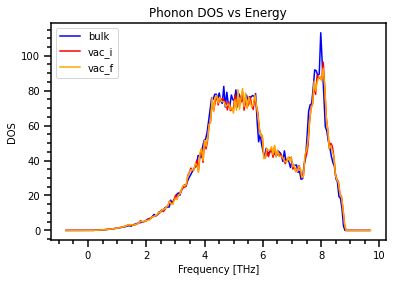

In [34]:
fig, ax = plt.subplots()
phono_bulk_1.plot_dos(ax=ax, color='b', label='bulk')
phon_vac_i.plot_dos(ax=ax, color='r', label='vac_i')
phon_vac_f.plot_dos(ax=ax, color='orange', label='vac_f')
plt.legend()

### Phonon Spectra

The pyiron implementation of phonopy makes it very easy to look at the spectra as shown here. 

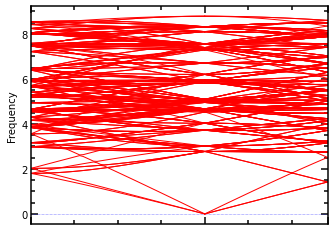

In [35]:
q_start = np.array([0.5, 0.5, 0.0])
q_end   = np.array([0.0, 0.0, 0.0])

bands = np.zeros((2,51,3))
bands[0] = np.linspace(q_start, q_end, 51)

q_start  = np.array([0.0, 0.0, 0.0])
q_end    = np.array([0.5, 0.0, 0.0])
bands[1] = np.linspace(q_start, q_end, 51)

phono_bulk_1.phonopy.set_band_structure(bands)

phono_bulk_1.phonopy.plot_band_structure().show();

### Attempt frequency

Now we get the attempt frequency by comparing the individual phonon spectra of initial and transition states

In [36]:
# Interpolate initial and final positions to guesstimate the transition state
sc_vac_ts = sc_vac_i.copy()
sc_vac_ts.positions = 0.5 * (sc_vac_i.positions + sc_vac_f.positions)

In [37]:
job_vac_ts = pr_vac.create_job(pr.job_type.Lammps, "VacancyTransition")
job_vac_ts.potential = pot
job_vac_ts.structure = sc_vac_ts


In [38]:
# We _don't_ relax this job, or it would fall into the initial or final state!
job_vac_ts.calc_static()
job_vac_ts.run()

2021-01-25 01:55:30,065 - pyiron_log - WARNING - The job VacancyTransition is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [39]:
phon_vac_ts = make_phonopy_job(job_vac_ts, "PhonoVacTransition")

In [40]:
phon_vac_ts.run()
tp_vac_ts = phon_vac_ts.get_thermal_properties(temperatures=temperatures) 

2021-01-25 01:55:40,228 - pyiron_log - WARNING - The job PhonoVacTransition is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


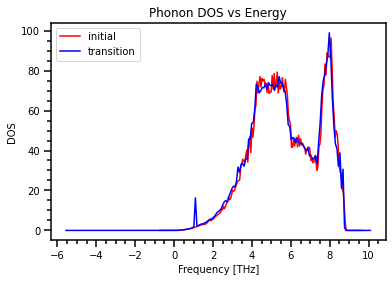

In [41]:
# The transition state has an imaginary mode (frequency < 0), let's see it
fig, ax = plt.subplots()
phon_vac_i.plot_dos(ax=ax, color='r', label='initial')
phon_vac_ts.plot_dos(ax=ax, color='b', label='transition')
plt.legend()

To calculate the attempt frequency, we'll ignore both the negative mode of the transition state (which we were warned about in the equation), as well as the three frequencies which correspond to rigid translation and are very near zero, and sometimes dip to be negative. Phonopy sorts the frequencies by magnitude, so we can just skip the first three and four for the initial and transition states, respectively. We take them at q=0.

In [42]:
freq_i = phon_vac_i.phonopy.get_frequencies(0)[3:] 
freq_ts = phon_vac_i.phonopy.get_frequencies(0)[4:]

In [43]:
print(np.prod(freq_i))

6.870306828107222e+236


Recall: $\nu_0^\star = \prod_{i=1}^{3N-3} \nu_i^\mathrm{IS} / \prod_{i=1}^{3N-4} \nu_i^\mathrm{TS}$

In [44]:
# Products are dangerous beasts, so we'll do a little numeric magic
nu = np.prod(freq_i[:-1] / freq_ts) * freq_i[-1]
print("Attempt frequency is ", nu, "THz (10^-12 s)")

Attempt frequency is  2.6826725642553253 THz (10^-12 s)


Mantina *et al.* (PRL 2008) report $\nu = 19.3$ THz using DFT and NEB, so our linearly-interpolated "transition state" with EAM is actually not doing so poorly.

There are many more things you can do with phonopy, including looking directly at the force constants, the Hessian matrix, etc. But hopefully this is a useful starting point.